# NAIRU Model

(Non-accelerating inflation rate of unemployment)

## Acknowledgements

This work has drawn on ideas and approaches in the following:

https://www.rba.gov.au/publications/bulletin/2017/jun/pdf/bu-0617-2-estimating-the-nairu-and-the-unemployment-gap.pdf

https://treasury.gov.au/sites/default/files/2021-04/p2021-164397_estimatingthenairuinaustralia.pdf

https://www.rba.gov.au/education/resources/explainers/pdf/nairu.pdf?v=2024-05-09-14-09-00

https://github.com/MacroDave/NAIRU

https://gross.substack.com/p/navigating-the-nairu?utm_source=publication-search

https://www.rbnz.govt.nz/-/media/project/sites/rbnz/files/publications/analytical-notes/2018/an2018-04.pdf

https://cmr.uni-koeln.de/fileadmin/wiso_fak/cmr/pdf/Berger_Publication_list/nairu.pdf

## Python set-up

In [1]:
import arviz as az
import numpy as np
import pandas as pd
import pymc as pm
import matplotlib.pyplot as plt
import statsmodels.api as sm  # for OLS

In [2]:
# local imports
from abs_data_capture import (
    get_abs_series, 
)
from rba_data_capture import (
    get_data_table_labels,
    get_data,
)
import plotting

## Data capture

Get the input data, map to quarterly where needed, diff where needed

In [3]:
PLOT_INPUTS: bool = False  # Whether to plot inputs

In [4]:
def monthly_to_quarterly(data: pd.Series) -> pd.Series:
    """Convert monthly data to quarterly data by taking the mean of 
    the three months in each quarter. Ignore quarters with less than 
    three months data. Drop NA items."""

    return (
        data
        .groupby(pd.PeriodIndex(data.index, freq="Q"))
        .agg(['mean', 'count'])
        .apply(lambda x: x['mean'] if x['count'] == 3 else np.nan, axis=1)
        .dropna()
    )


#### Inflation

In [5]:
# trimmed mean inflation
inflation_meta, inflation = get_abs_series(cat_id="6401.0", series_ids=["A3604510W"])
trimmed_mean = inflation["A3604510W"].dropna()  # Q/Q percent change, seasonally adjusted

Δρ = trimmed_mean
Δρ_1 = Δρ.shift(periods=1).dropna()
Δρ_2 = Δρ_1.shift(periods=1).dropna()
Δρ_3 = Δρ_1.shift(periods=1).dropna()


#### Inflation expectations (mix of real and synthetic data)

I have serious dobts about the synthetic data

In [6]:
# inflation expectations from survey
g3_meta, g3 = get_data("Inflation Expectations – G3")
expectations = g3["GBUSEXP"].dropna()  # Business inflation expectations – 3-months ahead, per cent per year
expectations.index = pd.PeriodIndex(expectations.index, freq="Q")

# Australian Government 10-year bond yield
bond_yields = pd.read_excel(
    "./NAIRU_INPUTS/RBA_bonds.xls", index_col=0, parse_dates=True, skiprows=10
)
bond_yield = monthly_to_quarterly(bond_yields["FCMYGBAG10"])
# There is a missing value in Q2 2013, so we will interpolate it
new_by_index = pd.period_range(start=bond_yield.index[0], end=bond_yield.index[-1], freq="Q")
bond_yield = bond_yield.reindex(new_by_index)
print("Missing values in bond yield: ", bond_yield[bond_yield.isna()].index)
bond_yield = bond_yield.interpolate(method="linear", limit_area="inside")

# let's construct a synthetic inflation expectations series - back as far as the trimmed mean
# using bond yields, trimmed_mean, and survey data
X = pd.DataFrame({"annual_bond_yield": bond_yield.loc[expectations.index]})
X['trimmed'] = trimmed_mean.loc[expectations.index]
X['time'] = np.arange(1.0, len(X)/10 + 1.0, 0.1)[::-1] 
X['const'] = 1.0
X = X.astype(float)
y = expectations.astype(float)
model = sm.OLS(y, X)
fit = model.fit()
#p = fit.summary()
#print(p)
ypred = fit.predict(X)
# And extrapolate
last_index = X.index[0] - 1
first_index = Δρ.index[0]
index_range = pd.period_range(start=first_index, end=last_index, freq="Q")
X_out = pd.DataFrame({"annual_bond_yield": bond_yield.loc[index_range]})
X_out['trimmed'] = trimmed_mean.loc[index_range]
starting = X.time.iloc[0] + 0.1
X_out['time'] = np.arange(start=starting, stop=len(X_out)/10 + starting -0.05, step=0.1)[::-1]
X_out['const'] = 1.0
oos = fit.predict(X_out) + 2  # add 2 to make it more realistic
i_expect = pd.concat([oos, y]).sort_index()
Δρe = i_expect.dropna()

if PLOT_INPUTS:
    pd.DataFrame({"Δρe": Δρe, "Δρ": Δρ}).plot(title="QonQ Inflation v Expectations")

Missing values in bond yield:  PeriodIndex(['2013Q2'], dtype='period[Q-DEC]')


#### Unemployment rate

In [7]:

# unemployment rate
lfs_meta, lfs = get_abs_series(cat_id="6202.0", series_ids=["A84423043C", "A84423047L"])
employed = lfs["A84423043C"]  # employed persons, thousands, seasonally adjusted
labour_force = lfs["A84423047L"]  # labour force, thousands, seasonally adjusted
ue_rate_m = ((1 - employed / labour_force) * 100).dropna()
U = monthly_to_quarterly(ue_rate_m)

ΔU_1 = U.diff(periods=1).dropna()
ΔU_1_over_U = (ΔU_1 / U).dropna()

if PLOT_INPUTS:
    ΔU_1_over_U.plot(title="Unemployment term: ΔU/U")

#### Import prices

In [8]:

# Import Price Index by Balance of Payments, index, original
trade_meta, trade = get_abs_series(cat_id="6457.0", series_ids=["A2298279F"])
log_import_prices = trade["A2298279F"].apply(np.log)
delta_log_import_prices = log_import_prices.diff(periods=4).dropna()
Δ4ρm_1 = delta_log_import_prices.shift(periods=1).dropna()
Δ4ρm_2 = delta_log_import_prices.shift(periods=2).dropna()

if PLOT_INPUTS:
    Δ4ρm_1.plot(title="Annual Growth in Import Prices")

#### Unit labour costs

In [9]:

# quarterly real unit labour costs growth
nat_accounts_meta, nat_accounts = get_abs_series(cat_id="5206.0", series_ids=["A2304402X", "A2302915V"])
log_ulc = (nat_accounts["A2302915V"]/nat_accounts["A2304402X"]).apply(np.log)
Δulc = (log_ulc.diff(1)).dropna() * 100

if PLOT_INPUTS:
    Δulc.plot(title="Real Unit Labour Costs Growth")

#### Global supply disriptions

In [10]:

# global supply chain disruptions
# https://www.newyorkfed.org/research/policy/gscpi#/interactive
gscpi = pd.read_excel(
    "./NAIRU_INPUTS/gscpi_data.xls", sheet_name="GSCPI Monthly Data", index_col=0, parse_dates=True
)["GSCPI"]
gscpi = monthly_to_quarterly(gscpi)
gscpi.index = pd.PeriodIndex(gscpi.index, freq="Q")
gscpi_1 = gscpi.shift(1).dropna()
gscpi_2 = gscpi.shift(2).dropna()

if PLOT_INPUTS:
    gscpi.plot(title="Global Supply Chain Disruptions")


## Data wrangling

Make sure all the vectors are the same length, with no missing data, and in the correct vector format

In [11]:
START = pd.Period("1986Q1", freq="Q")

inputs = pd.DataFrame(
    {
    "Δρ": Δρ,
    "Δρ_1": Δρ_1,
    "Δρ_2": Δρ_2,
    "Δρ_3": Δρ_3, 
    "Δρe": Δρe,
    "U": U,
    "ΔU_1_over_U": ΔU_1_over_U,
    "Δ4ρm_1": Δ4ρm_1,
    "Δ4ρm_2": Δ4ρm_2,
    "Δulc": Δulc,
    "gscpi_1": gscpi_1,
    "gscpi_2": gscpi_2,
    }
)
inputs = inputs[inputs.index >= START]
inputs['gscpi_dummy'] = inputs['gscpi_1'].isna().astype(float) # missing gscpi data
inputs['const'] = 1.0
for col_name in inputs.columns:
    if "gscpi" in col_name:
        inputs[col_name] = inputs[col_name].fillna(0)
display(inputs.isna().sum())  # check for missing values

inputs = inputs.dropna(how="any")  # Note ulc comes from Nat Accounts, which is delayed data
n_months = len(inputs)
print(f"Number of months: {n_months}; concluding: {inputs.index[-1]}")
input = {x: y.to_numpy() for x, y in inputs.items()}

Δρ             0
Δρ_1           0
Δρ_2           0
Δρ_3           0
Δρe            0
U              0
ΔU_1_over_U    0
Δ4ρm_1         0
Δ4ρm_2         0
Δulc           1
gscpi_1        0
gscpi_2        0
gscpi_dummy    0
const          0
dtype: int64

Number of months: 152; concluding: 2023Q4


## Bayesian model

#### The PyMC model

In [12]:
def inflation_equation(
    input: dict[str, np.ndarray], 
    model: pm.Model,
    nairu: pm.GaussianRandomWalk,
) -> None:
    """Inflation likelihood equation."""
    
    with model:
        alpha_i = pm.Normal("alpha_i", mu=0.0, sigma=0.1)
        beta1_i = pm.Normal("beta1_i", mu=0.24, sigma=0.1)
        beta2_i = pm.Normal("beta2_i", mu=0.16, sigma=0.1)
        beta3_i = pm.Normal("beta3_i", mu=0.18, sigma=0.1)
        gamma_i = pm.Normal("gamma_i", mu=-0.39, sigma=0.2)
        delta_i = pm.Normal("delta_i", mu=0.35, sigma=0.1)
        chi1_i = pm.Normal("chi1_i", mu=0.5, sigma=0.1)
        chi2_i = pm.Normal("chi2_i", mu=0.5, sigma=0.1)
        chi3_i = pm.Normal("chi3_i", mu=0.5, sigma=0.1)
        llambda_i = pm.Normal("llambda_i", mu=0.5, sigma=0.1)
        const_i = pm.Normal("const_i", mu=0.0, sigma=10)

        observed_i = pm.Normal(
            "observed_i",
            mu = alpha_i * (input["Δ4ρm_1"] - input["Δ4ρm_2"])
            + beta1_i * input["Δρ_1"] + beta2_i * input["Δρ_2"] + beta3_i * input["Δρ_3"]
            + gamma_i * (input["U"] - nairu)/input["U"] 
            + delta_i * input["Δρe"]
            + llambda_i * input["ΔU_1_over_U"]
            + chi1_i * input["gscpi_1"] + chi2_i * input["gscpi_2"] + chi3_i * input["gscpi_dummy"]
            + const_i * input["const"],
            sigma=0.1,
            observed=input["Δρ"],
        )

def ulc_equation(
    input: dict[str, np.ndarray],
    model: pm.Model,
    nairu: pm.GaussianRandomWalk
) -> None:
    """Unit labour costs likelihood equation."""

    with model:
        delta_l = pm.Normal("delta_l", mu=-0.45, sigma=0.21)
        omega1_l = pm.Normal("omega1_l", mu=0.4, sigma=0.5)
        omega2_l = pm.Normal("omega2_l", mu=0.4, sigma=0.5)
        gamma_l = pm.Normal("gamma_l", mu=-1.9, sigma=0.5)
        llambda_l = pm.Normal("llambda_l", mu=-5.6, sigma=2.0)
        const_l = pm.Normal("const_l", mu=0.0, sigma=10)
        observed_l = pm.Normal(
            "observed_l",
            mu = delta_l * input["Δρe"]
            + omega1_l * input["Δρ_1"] + omega2_l * input["Δρ_2"]
            + gamma_l * ((input["U"] - nairu)/input["U"])
            + llambda_l * input["ΔU_1_over_U"]
            + const_l * input["const"],
            sigma=0.5,
            observed=input["Δulc"],
        )

def nairu_equation(input: dict[str, np.ndarray], model) -> pm.GaussianRandomWalk:
    """Gaussian random walk for the NAIRU."""

    with model:
        nairu_start = pm.Normal.dist(mu=6, sigma=2.5)
        nairu_innovation = pm.Normal("nairu_innovation", mu=0.2, sigma=0.1)
        #nairu_innovation = pm.InverseGamma("nairu_innovation", alpha=3, beta=0.1)
        nairu = pm.GaussianRandomWalk(
            "nairu",
            mu=0,  # no drift in this model
            sigma=nairu_innovation,
            init_dist=nairu_start,
            steps=n_months-1,
        )
    return nairu


def define_model(input: dict[str, np.ndarray]) -> pm.Model:
    """Define the model for the NAIRU estimation."""

    model = pm.Model()

    nairu = nairu_equation(input, model)
    inflation_equation(input, model, nairu)
    ulc_equation(input, model, nairu)        

    return model


model = define_model(input)

#### Generate a map of the model

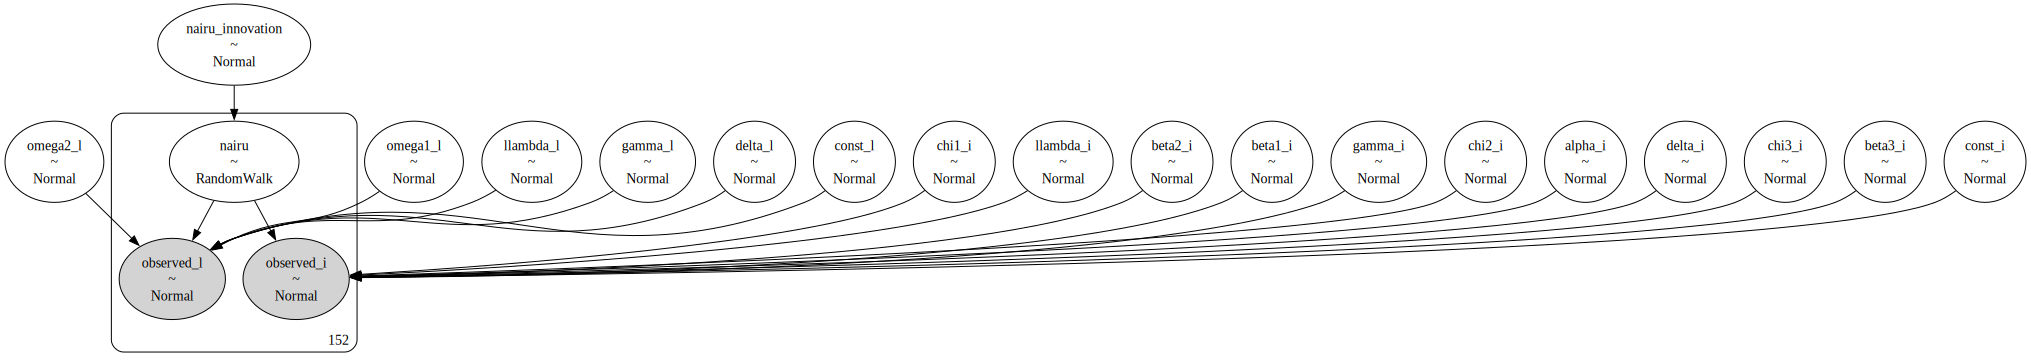

In [13]:
def produce_model_map(m: pm.Model) -> None:
    """Produce a map of the model."""
    
    gv = pm.model_to_graphviz(m)
    gv.render(
        format="png",
        filename=("./NAIRU_INPUTS/nairu model"),
    )
    display(gv)


produce_model_map(model)

#### Fit the model to the data

In [14]:
N_CORES: int = 8
SAMPLES: int = 80_000
SAMPLES_PER_CORE: int = int(SAMPLES / N_CORES)
TUNE: int = 2_000

SAMPLE_ARGS = {
    "draws": SAMPLES_PER_CORE,
    "tune": TUNE,
    "cores": N_CORES,
    "chains": N_CORES,
    "nuts_sampler": "numpyro",
}

  0%|          | 0/12000 [00:00<?, ?it/s]

  0%|          | 0/12000 [00:00<?, ?it/s]

  0%|          | 0/12000 [00:00<?, ?it/s]

  0%|          | 0/12000 [00:00<?, ?it/s]

  0%|          | 0/12000 [00:00<?, ?it/s]

  0%|          | 0/12000 [00:00<?, ?it/s]

  0%|          | 0/12000 [00:00<?, ?it/s]

  0%|          | 0/12000 [00:00<?, ?it/s]

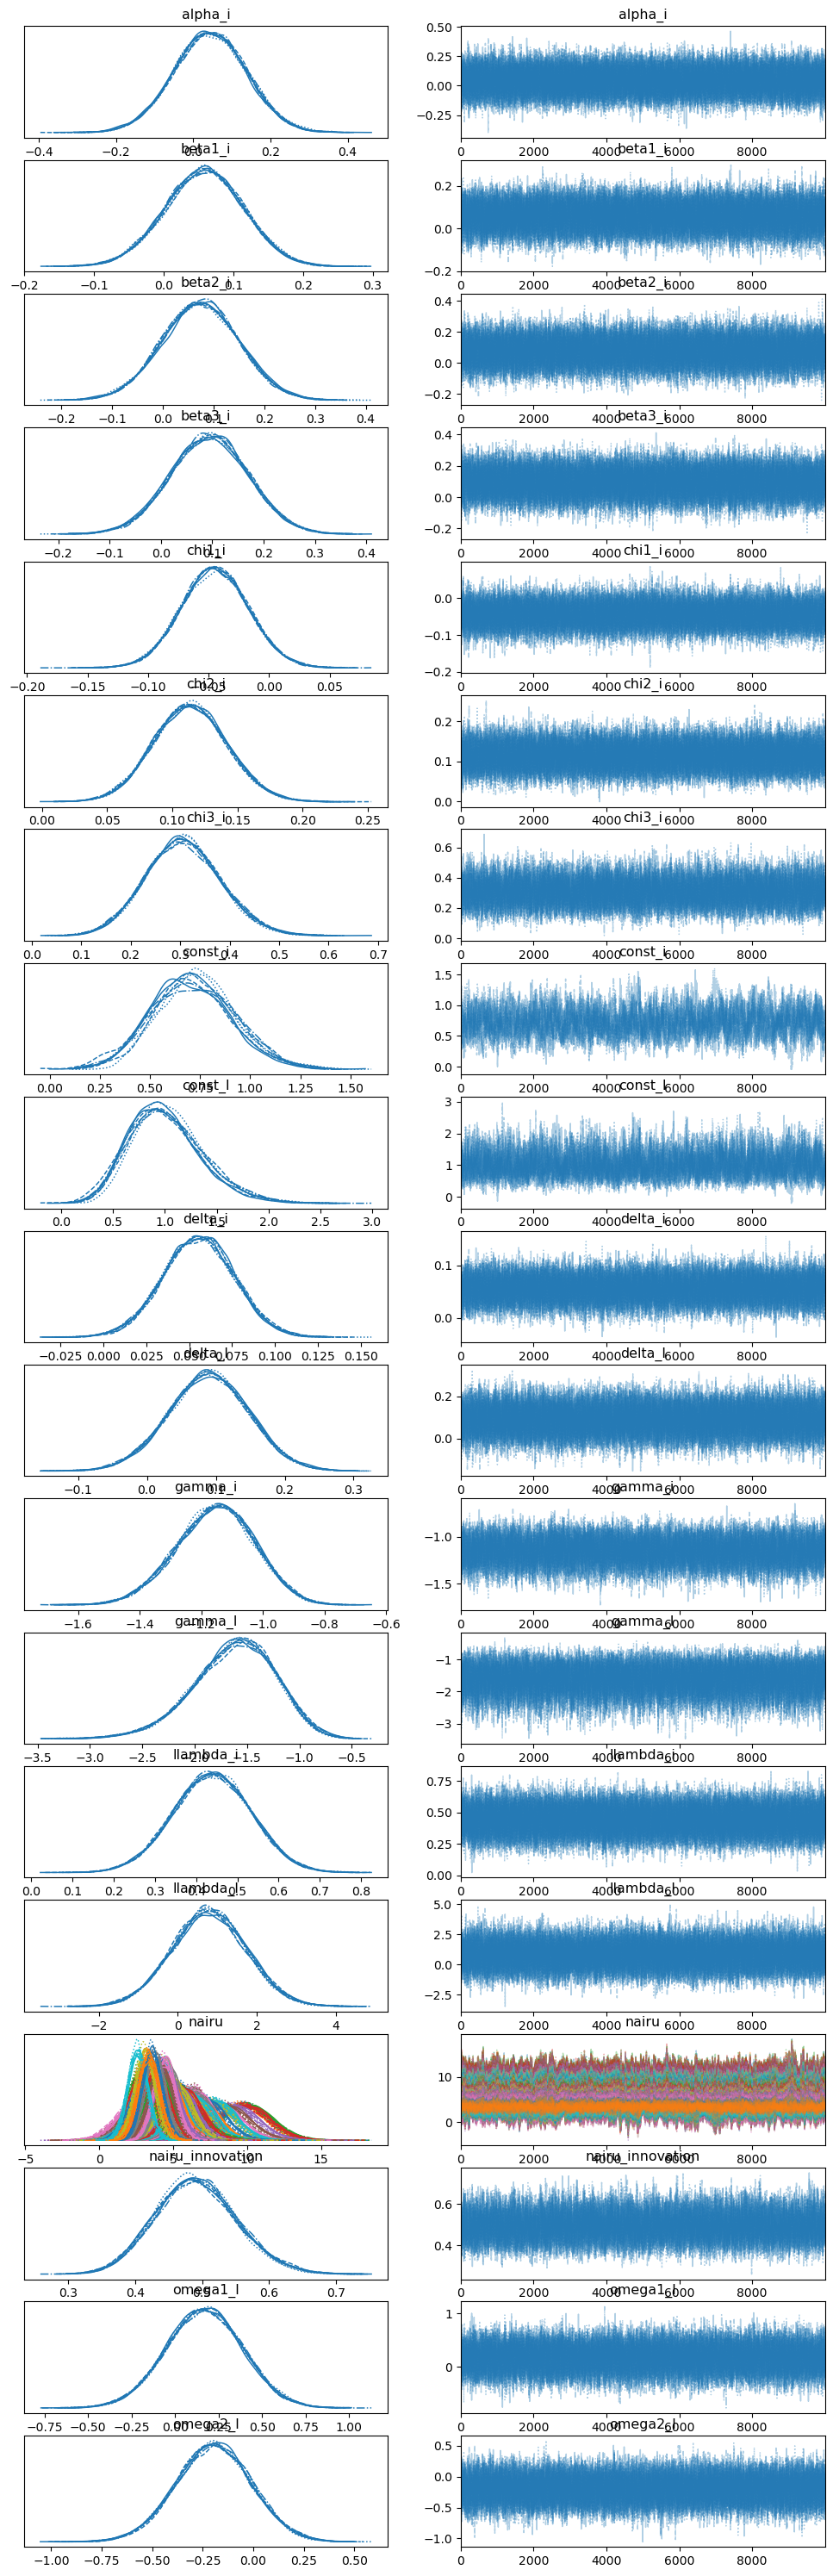

In [15]:
def fit_the_model(model: pm.Model) -> az.InferenceData:
    """Fit the data to the model."""
    
    with model:
        idata = pm.sample(
            **SAMPLE_ARGS,
            progressbar=True,
            return_inferencedata=True,
        )
        az.plot_trace(idata)
    return idata


trace = fit_the_model(model)

## Check diagnostics

In [16]:
def check_trace(trace: az.InferenceData) -> None:
    """Check the trace for potential problems."""

    def warn(w: bool) -> str:
        return '--- THERE BE DRAGONS ---> ' if w else ''
    
    summary = az.summary(trace)

    max_r_hat = 1.01
    statistic = summary.r_hat.max()
    print(f"{warn(statistic > max_r_hat)}Maximum R-hat convergence diagnostic: {statistic}")

    min_ess = 400
    statistic = summary[["ess_tail", "ess_bulk"]].min().min()
    print(f"{warn(statistic < min_ess)}Minimum effective sample size (ESS) estimate: {statistic}")

    try:
        diverging_count = int(np.sum(trace.sample_stats.diverging))
    except (ValueError, AttributeError):  # No sample_stats, or no .diverging
        diverging_count = 0
    print(f"{warn(diverging_count > 0)}Divergent transitions in HMC sampling: {diverging_count}")  


check_trace(trace)

Maximum R-hat convergence diagnostic: 1.01
Minimum effective sample size (ESS) estimate: 1120.0
Divergent transitions in HMC sampling: 0


## Results

In [17]:
# save charts in this notebook
plt.style.use("fivethirtyeight")
CHART_DIR = "./CHARTS/NAIRU/"
plotting.set_chart_dir(CHART_DIR)
plotting.clear_chart_dir(CHART_DIR)

# display charts in this notebook
SHOW = False

In [18]:
def get_var(var_name: str, trace: az.InferenceData) -> pd.DataFrame:
    """Extract the chains/draws for a specified var_name."""

    return (
        az.extract(trace, var_names=var_name)
        .transpose("sample", ...)
        .to_dataframe()[var_name]
        .unstack(level=2)
        .T
    )

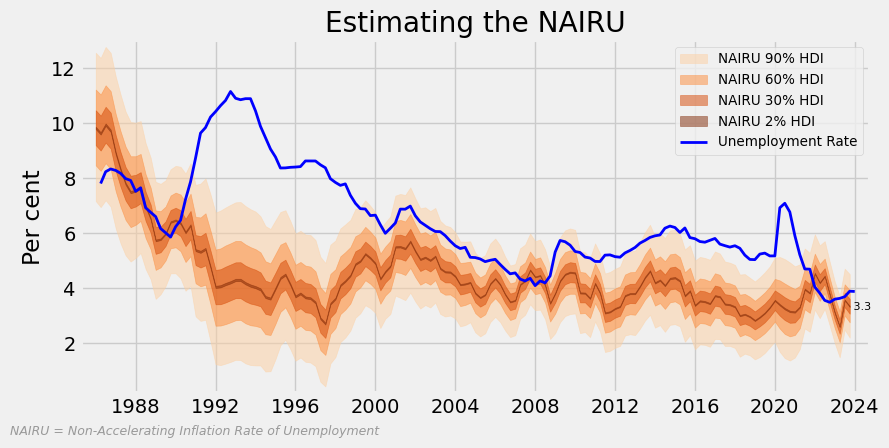

In [19]:
def plot_nairu(trace: az.InferenceData) -> None:
    """Plot the NAIRU."""

    nairu = get_var("nairu", trace)
    nairu.index = inputs.index.to_timestamp()
    PERCENTS = [5, 20, 35, 49]
    _COLORS = [(p - min(PERCENTS)) / (max(PERCENTS) - min(PERCENTS)) for p in PERCENTS]
    MIN_COLOR = 0.25
    COLOR_FRACS = [c * (1.0 - MIN_COLOR) + MIN_COLOR for c in _COLORS]
    palette = "Oranges"
    _, ax = plt.subplots()
    cmap = plt.get_cmap(palette)

    for i, p in enumerate(PERCENTS):
        quants = p, 100 - p
        label = f"NAIRU {quants[1] - quants[0]}% HDI"
        lower, upper = [nairu.quantile(q=q / 100.0, axis=1) for q in quants]
        color = COLOR_FRACS[i]
        ax.fill_between(
            nairu.index,
            upper,
            lower,
            color=cmap(color),
            alpha=0.5,
            label=label,
            zorder=i + 1,
        )
    FU = U[U.index > START]
    ax.plot(
        FU.index.to_timestamp(),
        FU,
        color="blue",
        lw=2,
        label="Unemployment Rate",
        zorder=10,
    )
    latest = round(nairu.iloc[-1].quantile(0.5), 1)
    ax.text(nairu.index[-1], latest, f" {latest}", va="center", ha="left", color="black", fontsize=8)
    plotting.finalise_plot(
        ax,
        title="Estimating the NAIRU",
        ylabel="Per cent",
        legend={"loc": "upper right", "fontsize": "x-small"},
        lfooter="NAIRU = Non-Accelerating Inflation Rate of Unemployment",
        show=True,
    )


plot_nairu(trace)

In [20]:
def print_parameter_summary() -> None:
    """Print the summary results of the model,
       useful for non-vector free variables in the model."""

    q = [0.025, 0.5 , 0.975]
    results = {str(name): (
        az.extract(trace, var_names=str(name))
        .to_dataframe()[str(name)]
        .quantile(q)) for name in model.free_RVs
        if str(name) not in ["nairu"]
    }
    display(pd.DataFrame(results).T.sort_index())


print_parameter_summary()

,0.025,0.500,0.975
alpha_i,-0.141648,0.043068,0.227753
beta1_i,-0.052662,0.058869,0.167809
beta2_i,-0.075307,0.073898,0.222532
beta3_i,-0.054752,0.094859,0.243867
chi1_i,-0.099243,-0.044907,0.010365
chi2_i,0.058640,0.113529,0.170304
chi3_i,0.160912,0.304835,0.460572
const_i,0.330269,0.712900,1.137478
const_l,0.409966,0.980723,1.805095
delta_i,0.014007,0.055403,0.096311
